<a href="https://colab.research.google.com/github/vikaskapur/MyRL/blob/main/MAB/mab_implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Building A Static Environment

In [ ]:
class Environment(object):

  def __init__(self, reward_probabilities, actual_rewards):
    if len(reward_probabilities) != len(actual_rewards):
      raise Exception(f"size of reward_probabilities : {len(reward_probabilities)} does not match size of actual rewards : {len(actual_rewards)}")

    self.reward_probabilities = reward_probabilities
    self.actual_rewards = actual_rewards
    self.k_arms = len(reward_probabilities)

  def choose_arm(self, arm):
    if arm < 0 or arm >= self.k_arms:
      raise Exception(f"arm must be between 0 and {self.k_arms -1}")

    return self.actual_rewards[arm] if np.random.random() < self.reward_probabilities[arm] else 0.0

In [ ]:
env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])

In [ ]:
[env.choose_arm(1) for _ in range(10)]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
[env.choose_arm(2) for _ in range(10)]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
[env.choose_arm(0) for _ in range(10)]

[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]

In [ ]:
[env.choose_arm(3) for _ in range(10)]

[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]

### Calculationg Average Through Incremental Sampling

The obvious way to calculate the average of a finite set of numbers it to sum the list of numbers and divide by the length of the list. However, it is not always feasible to store all numbers into a list before calculating their average. The incremental sampling technique is a memory-efficient way of estimating the average of a larger collection of numbers on the fly. See the formular below and let's turn that into code : 

 **new_estimage = old_estimate + (1/n) * (reward - old_estimate)**

or more generally,

**new_estimage = old_estimate + (step_size) * (reward - old_estimate)**

Now, let's translate this formula into code.


### Incremental Sampling For Non-Stationary Bandit Problems

**new_estimage = old_estimate + (1/n) * (reward - old_estimate)**

In the incremental sampling formular above, the term **(1/n)** gets smaller as **n** gets larger. This means that, rewards from later time steps contribute little to the new estimate of the average and this makes it unfit for bandit problems with non-stationary reward distributions. To curb this, another form of this formula with a **fixed** step size should be used. The step size must be a number between **0 and 1**. This way, rewards from later time steps contribute more to the estimation of the average and this makes it fit for non-stationary bandit problems. The following general update rule is very common throughout Reinforcement Learning especially in Temporal Difference learning algorithms.

**new_estimage = old_estimate + (step_size) * (reward - old_estimate)**

Let's verify this in code.

In [ ]:
time_steps = np.arange(1,50)
weights = 1/time_steps

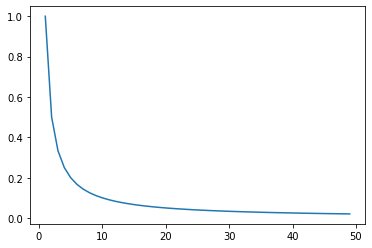

In [ ]:
plt.plot(time_steps, weights)

### Implementing A Random-Behaving Agent

In [ ]:
class RandomAgent(object):

  def __init__(self, env, max_iterations=500):
    self.env = env
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.random.choice(self.env.k_arms)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}



In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
random_agent = RandomAgent(test_env)
random_agent_result = random_agent.act()

In [ ]:
total_rewards = sum(random_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 243.0


<BarContainer object of 4 artists>

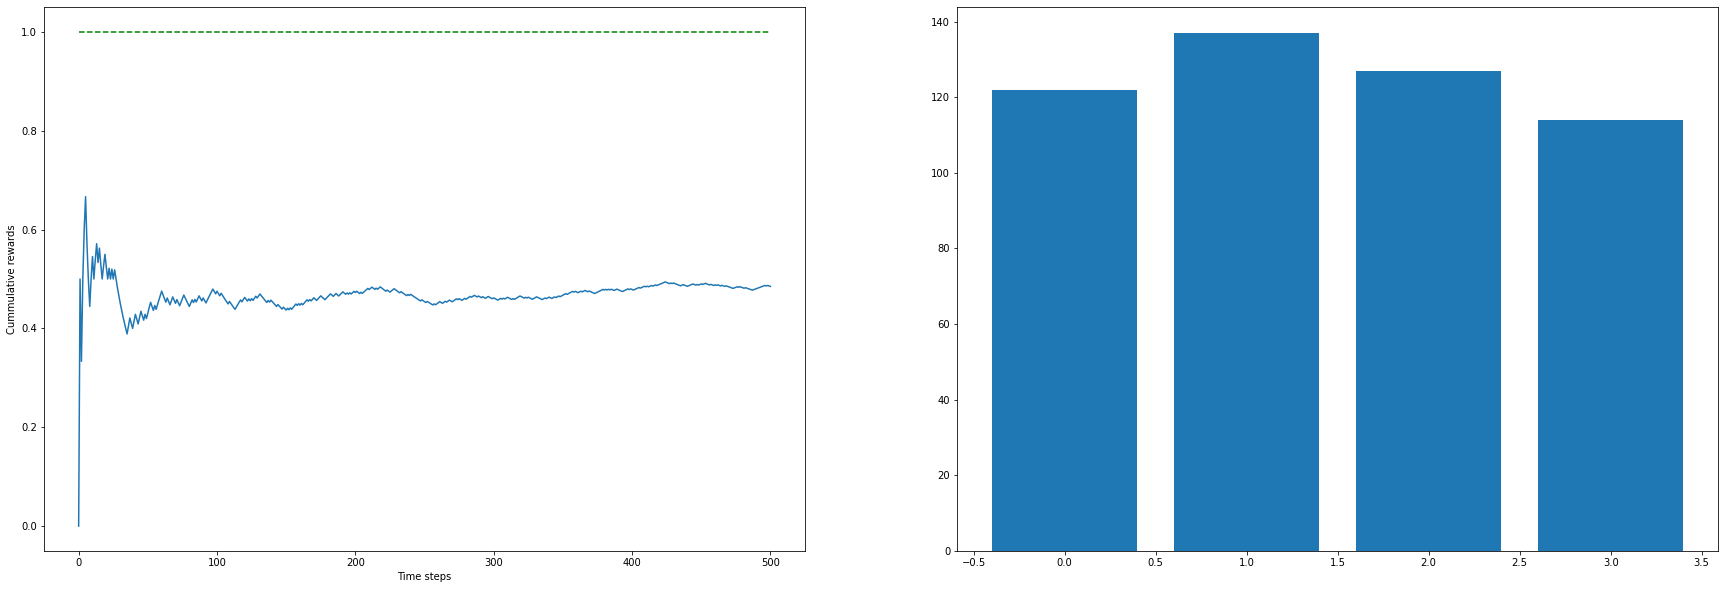

In [ ]:
cum_rewards = random_agent_result["cum_rewards"]
arm_counts = random_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(random_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [ ]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {random_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.56557377 0.05109489 0.86614173 0.5       ]


### Implementing A Greedy Agent

In [ ]:
class GreedyAgent(object):

  def __init__(self, env, max_iterations=500):
    self.env = env
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.argmax(self.q_values)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}


In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
greedy_agent = GreedyAgent(test_env)
greedy_agent_result = greedy_agent.act()

In [ ]:
total_rewards = sum(greedy_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 302.0


<BarContainer object of 4 artists>

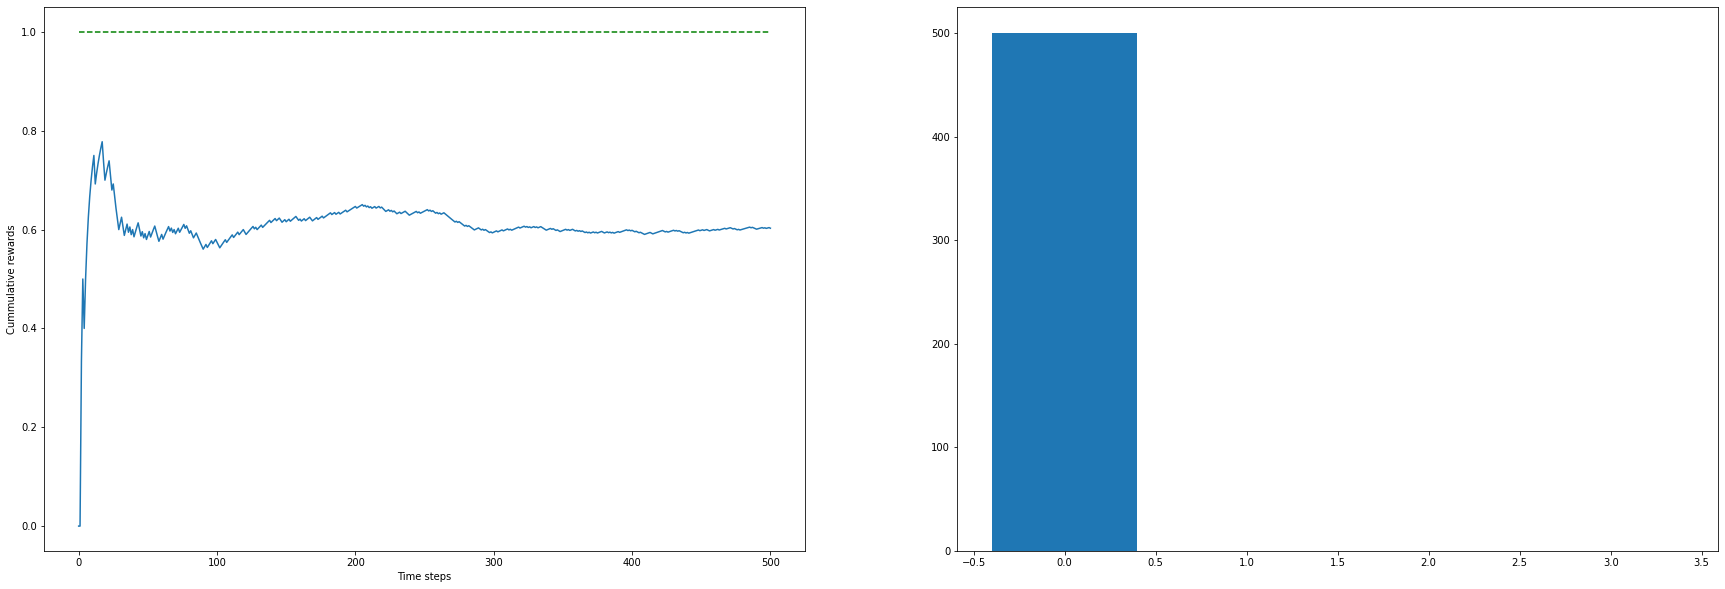

In [ ]:
cum_rewards = greedy_agent_result["cum_rewards"]
arm_counts = greedy_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(greedy_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [ ]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {greedy_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.604 0.    0.    0.   ]


### Balancing Exploration & Exploitation With Epsilon-Greedy Agents

In [ ]:
class EpsilonGreedyAgent(object):

  def __init__(self, env, max_iterations=500, epsilon=0.01, decay_rate=0.01, decay_interval=50):
    self.env = env
    self.iterations = max_iterations
    self.epsilon = epsilon
    self.decay_rate = decay_rate
    self.decay_interval = decay_interval

    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.random.choice(self.env.k_arms) if np.random.random() < self.epsilon else np.argmax(self.q_values)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

      if i % self.decay_interval == 0:
        self.epsilon = self.epsilon * self.decay_rate

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}


In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
egreedy_agent = EpsilonGreedyAgent(test_env, epsilon=0.1, decay_rate=1.0, decay_interval=50)
egreedy_agent_result = egreedy_agent.act()

In [ ]:
total_rewards = sum(egreedy_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 384.0


<BarContainer object of 4 artists>

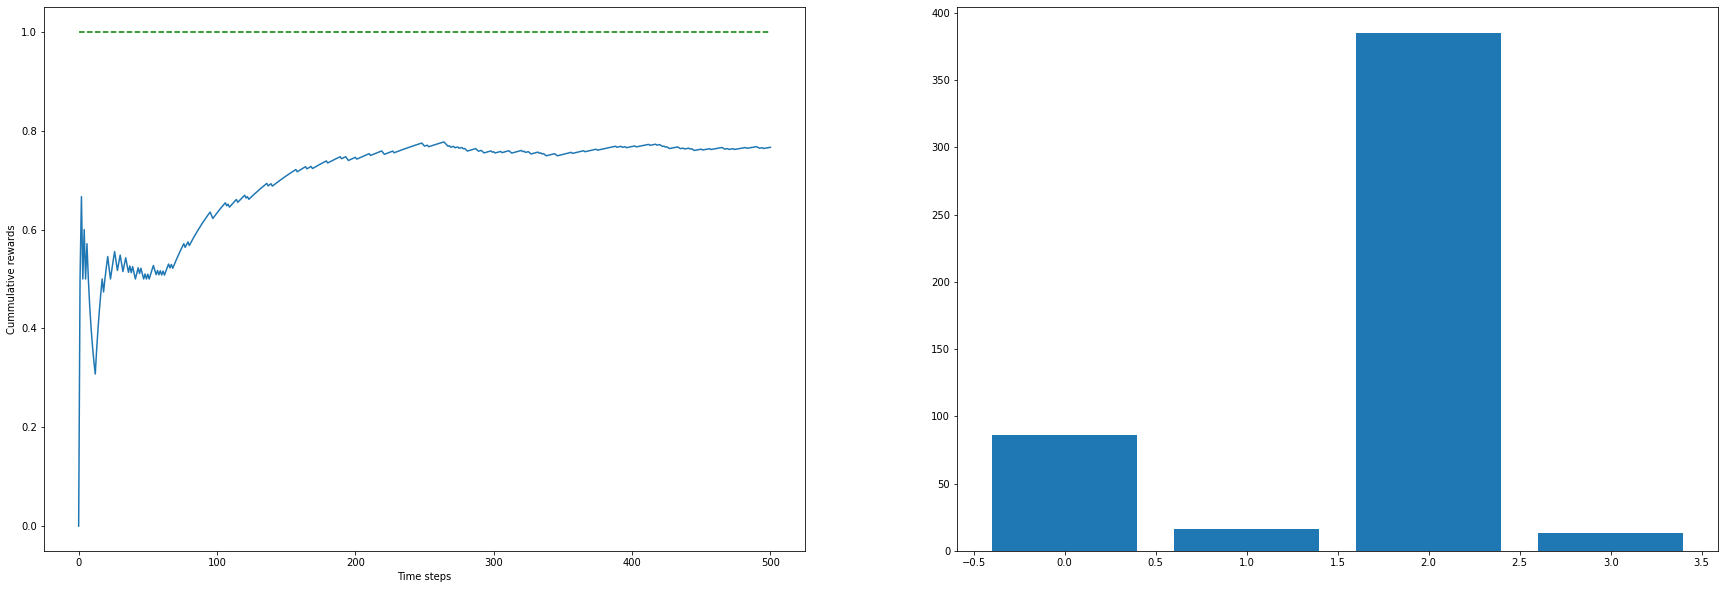

In [ ]:
cum_rewards = egreedy_agent_result["cum_rewards"]
arm_counts = egreedy_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(egreedy_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [ ]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {egreedy_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.60465116 0.0625     0.84155844 0.53846154]


### Intelligent Exploration With Softmax/Boltzmann Distribution

All non-best actions (arms) we equivalently considered in the epsilon-greedy strategy but there should be a better way. Think of medical trials for a moment. Would you randomly pick non-best medications or you'll want to be better informed?

With the Softmax Exploration algorithm, actions are selected based on the Boltzmann Distribution with the formular below : 

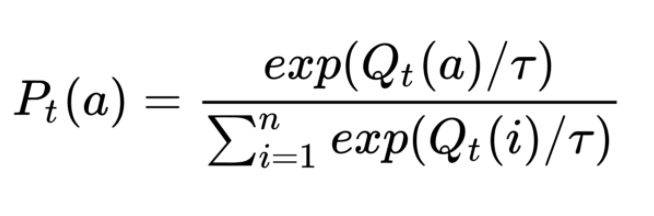

tau, the temperature factor specifies how many random arms we can explore. 

In [ ]:
class SoftmaxExplorationAgent(object):

  def __init__(self, env, max_iterations=500, tau=0.5):
    self.env = env
    self.iterations = max_iterations
    self.tau = tau

    self.action_probas = np.zeros(self.env.k_arms)
    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      self.action_probas = np.exp(self.q_values/self.tau) / np.sum(np.exp(self.q_values/self.tau))
      arm = np.random.choice(self.env.k_arms, p=self.action_probas)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
softmax_agent = SoftmaxExplorationAgent(test_env, tau=0.015, max_iterations=2000)
softmax_agent_result = softmax_agent.act()

In [ ]:
total_rewards = sum(softmax_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 1732.0


<BarContainer object of 4 artists>

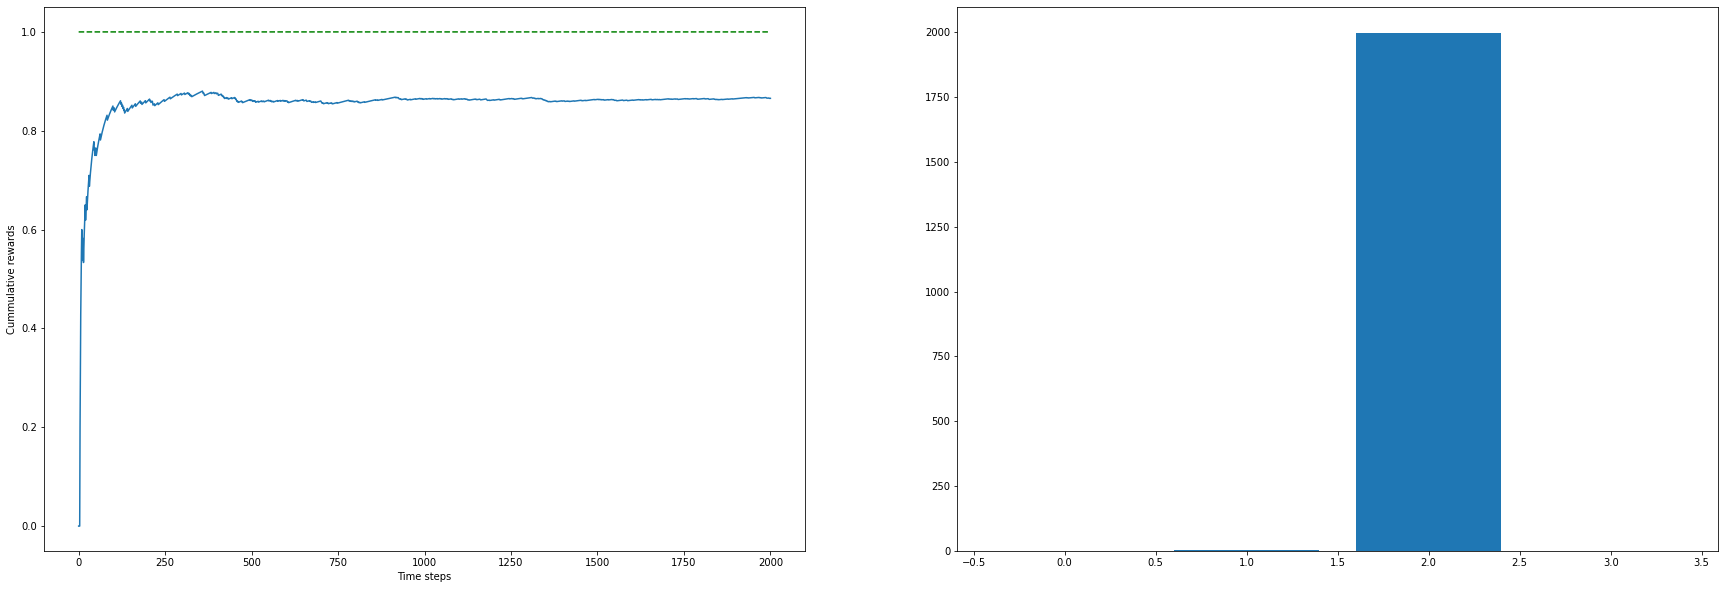

In [ ]:
cum_rewards = softmax_agent_result["cum_rewards"]
arm_counts = softmax_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(softmax_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

### Inducing Exploration With Optimistic Initialization (Optimism in the face of uncertainty)

In this approach, we design the agent to treat actions that have not been explored sufficiently as if they were the best actions. To do this, we have to initialize the agent's Q values to high values to make it act greedily using these estimates. To maintain the induction of exploration in the agent, we also need to initialize the arm_counts to values higher than one otherwise the Q values will change too quickly and the effect of this strategy will be reduced.

As the agent interacts with the environment and update the Q values, they will converge to their true mean/average values.



In [ ]:
class OptimisticAgent(object):

  def __init__(self, env, initial_q=1.0, initial_visits=50, max_iterations=500):
    self.env = env
    self.iterations = max_iterations
    self.initial_q = initial_q
    self.initial_visits = initial_visits

    self.q_values = np.ones(self.env.k_arms) * self.initial_q
    self.arm_counts = np.ones(self.env.k_arms) * self.initial_visits
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.argmax(self.q_values)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}



In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
optimistic_agent = OptimisticAgent(test_env)
optimistic_agent_result = optimistic_agent.act()

In [ ]:
total_rewards = sum(optimistic_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 421.0


<BarContainer object of 4 artists>

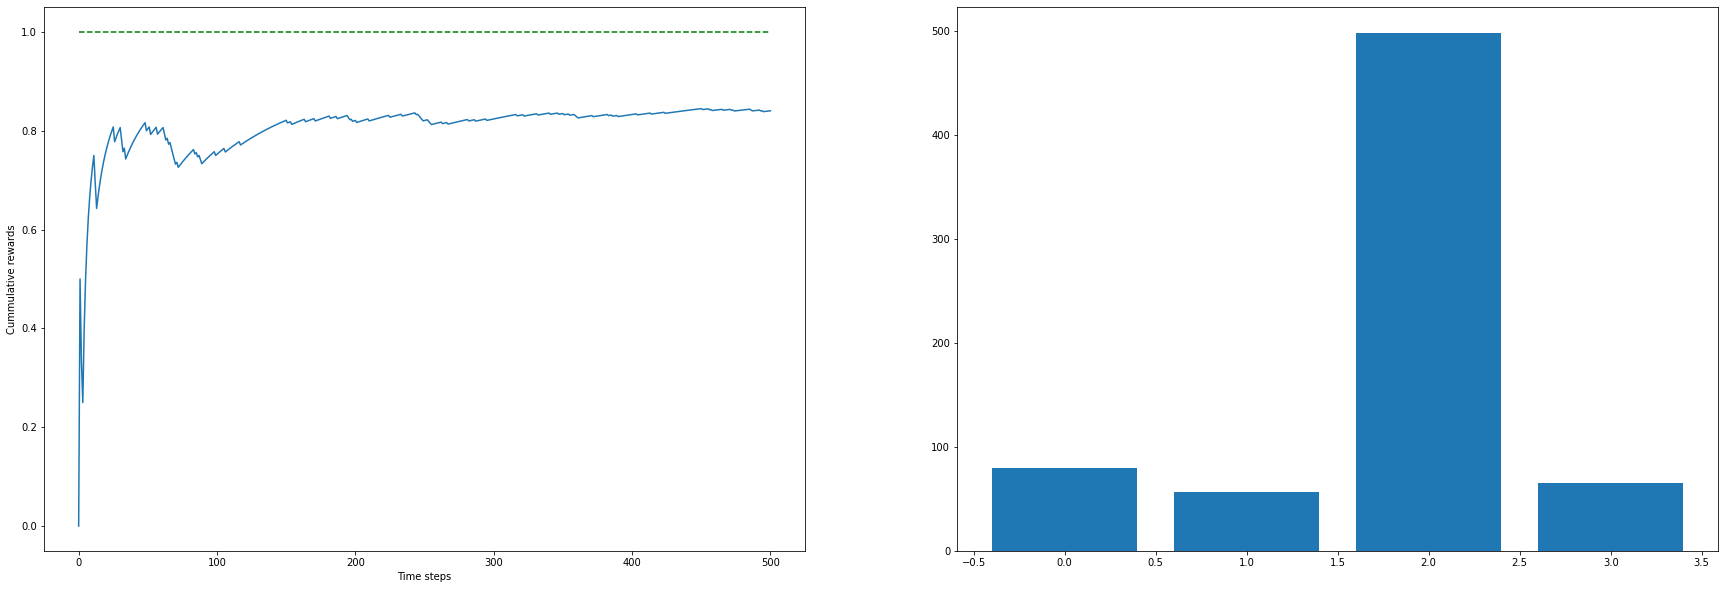

In [ ]:
cum_rewards = optimistic_agent_result["cum_rewards"]
arm_counts = optimistic_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(optimistic_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [ ]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {optimistic_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.8875     0.87719298 0.88955823 0.87692308]


### Realistic Optimism With The Upper Confidence Bounds (UCB) Algorithm

There are two fundamental issues with the Optimistic Initialization strategy that we implemented in the previous section: 

1. For most real-life MAB problems, we won't know the true underlying reward probabilities in order to properly initialize the Q values of the agent. If we set the Q values to be much higher than the true reward probabilities the agent will perform sub-optimally since it will take several rounds of interactions for the Q values to converge.

2. Also the initial_visits as used in the Optimistic agent represents uncertainty in our estimates and it requires tunning. Remember that there is not best way to figure out hyperparameters without experimentation and this makes it hard.

So a better strategy is to use a statistical technique to calculate the initial Q value's uncertainty and use that to influence exploration. This is called the Upper Confidence Bounds (UCB) and it is given by the formular below : 

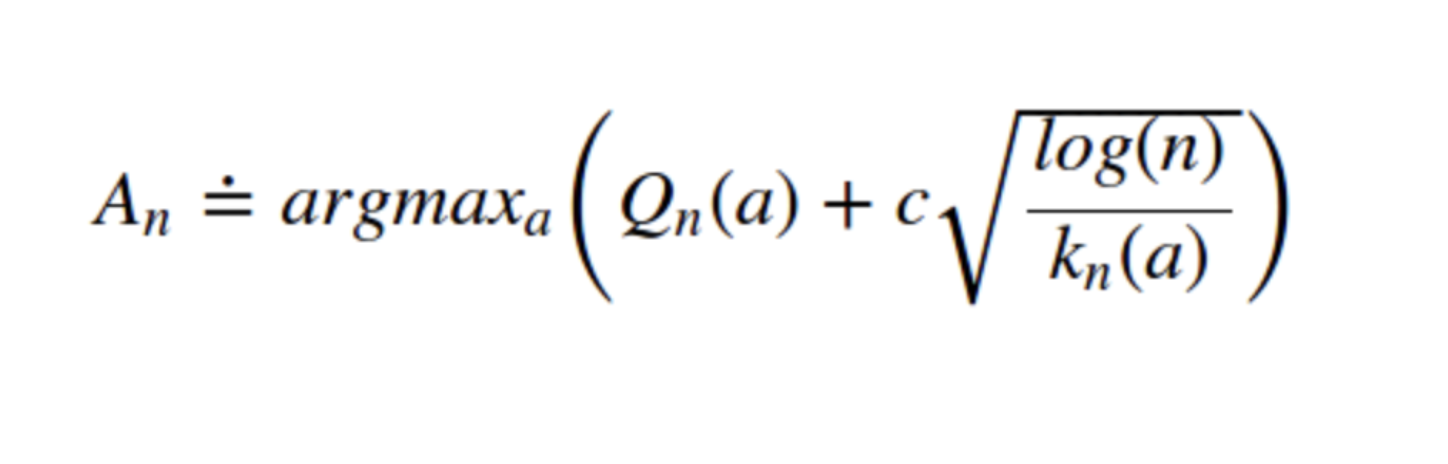

In [ ]:
class UCBAgent(object):

  def __init__(self, env, c=2, max_iterations=500):
    self.env = env
    self.c = c
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms, dtype=np.float32)
    self.arm_counts = np.zeros(self.env.k_arms, dtype=np.int)
    self.arm_rewards = np.zeros(self.env.k_arms, dtype=np.float32)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(0, self.iterations):
      if i < len(self.q_values):
        arm = i
      else:
        U = self.c * np.sqrt(np.log(i) / self.arm_counts)
        arm = np.argmax(self.q_values + U)

      reward = self.env.choose_arm(arm)

      self.arm_rewards[arm] += reward
      self.arm_counts[arm] += 1
      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])

      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards)/len(self.rewards))

    return {"arm_counts" : self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}
        

In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
ucb_agent = UCBAgent(test_env, c=1)
ucb_agent_result = ucb_agent.act()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [ ]:
total_rewards = sum(ucb_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 413.0


<BarContainer object of 4 artists>

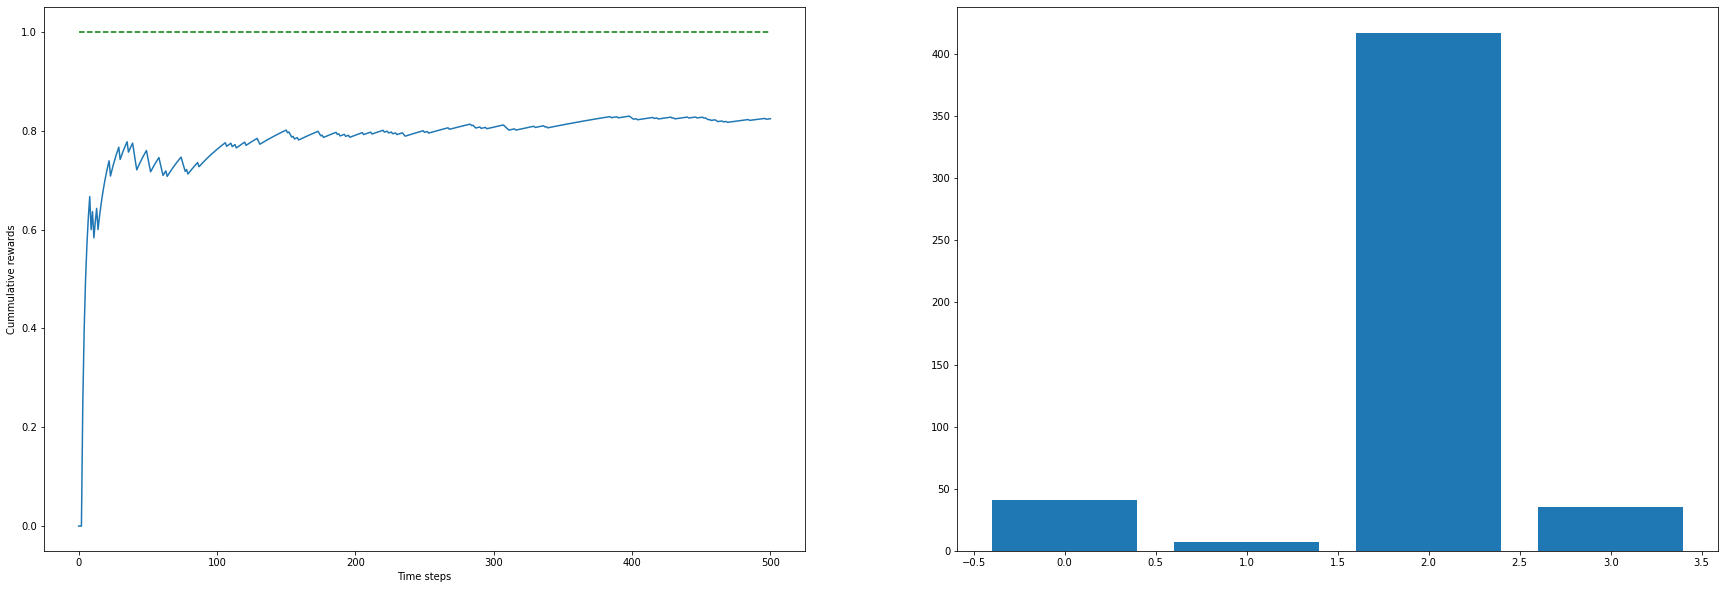

In [ ]:
cum_rewards = ucb_agent_result["cum_rewards"]
arm_counts = ucb_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(ucb_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)